# MUON BEAM DUMP

This notebook will calculate expected yields for the bremsstrahlung production of scalar, pseudoscalar, vector, and pseudovector particles ($X$) at a hypothetical muon beam dump experiment, as a function of the new particle mass ($m_X$) and coupling to muons ($\epsilon_X$ times the electron charge).

This notebook is organized into four steps. In pricinple, all these steps can be run manually using the relevant `.py` files, and with more flexibility in parameters, but this notebook serves as a convenient pipeline to do everything at once.

1. First, parameters are specified. This includes information about the beam, the target material, allowed decays, and experimental parameters. Any time a parameter is changed, a new directory with a new config file is created in `/experiments/TARGETNAME/...`, where all information regarding the run will be saved.
2. Next, cross sections are calculated using the Weizsäcker-Williams approximation and the Improved Weizsäcker-Williams approximation as a function of the above parameters and saves them. This step takes considerable time, but the code will automatically check for existing cross section files, assuming you use the default directory naming system. This does not need to be recalculated every time, only certain parameter changes such as energy and target material require reruns. See the file `cross_sections.py` for more details.
3. Using the above cross sections, event yields are calculated using `event_yields.py`. This primarily makes use of the `decay dictionary` parameter, where the model is specified. Saves a 2D array of expected event bins as a function of $m_X$ and $\epsilon_X$.
4. Plots! If you already have cross section and event yields saved, feel free to skip to this step.

In [1]:
import numpy as np

# Step 0: Parameters

Change this as you like! Some parameters are labeled `DO NOT CHANGE` -- this notebook is not equipped to handle changing these parameters automatically, but it is possible to manually change them using the relevant `.py` files.

In [2]:
from config import build_cross_section_config
from config import build_full_config

# Beam Parameters
E_0 = 1500          # Beam Energy [GeV]
m_lepton = 0.105    # Colliding lepton mass [GeV] # DO NOT CHANGE
N_mu = 1e20         # Total number of muons on target

# Dump Parameters
theta_max = 1e-2                # Maximum allowed emission angle [rad] # DO NOT CHANGE
target_name = "Water"
target_Z = 10                # Target nucleus's electric charge
target_A = 18.02             # Target atomic mass [g/mol] ~ [GeV]
target_density = 1           # Target material density [g/cm3]
target_length = 10          # Length of target [m]
shield_length = 10          # Length of shield [m]
detector_length = 100       # Length of detector [m]

# Model Parameters
model_name_string = "darkX"
decay_dictionary = { # Format is [weight, mass]
                    "electrons" : [1, 0.000511],
                    "muons" : [1, 0.105],
                    "taus" : [1, 1.776],
                    "neutrinos" : [0, 0],
                    "hadrons" : [1, 0.105], # Weight gets multiplied by Rpp
                    }

# Calculation parameters
run_WW =  True                      # Whether to use the full WW approximation or just IWW
if E_0 > 50:
    run_WW = False                  # Highly recommended to set run_WW to False for large energies, takes forever otherwise!
xbins = 1000                    
cases = ["Scalar", "Pseudoscalar", "Vector", "Axial Vector"]    # DO NOT CHANGE
m_Xs = np.logspace(-3, 3, 25)       # Range of X masses to compute for interpolation
plot_mrange = (-2, 1.5)
plot_erange = (-9, -2)

# Directories
cross_section_dir = f"experiments/{target_name}/cross_sections/"
experiment_dir = f"experiments/{target_name}/experiment_{model_name_string}_e{E_0}_t{target_length}_s{shield_length}_d{detector_length}/"

In [3]:
# ##### BUILD CONFIG FILES #####

# TODO: fix this function to use keyword args for convenience 
cross_section_config = build_cross_section_config(run_WW, xbins, cases, m_Xs, cross_section_dir, E_0, m_lepton, theta_max, target_name, target_Z, target_A)
config = build_full_config(run_WW, xbins, cases, m_Xs, cross_section_dir, experiment_dir, E_0, m_lepton, theta_max, target_name, target_Z, target_A, target_density, target_length, shield_length, detector_length,  model_name_string, decay_dictionary, N_mu, plot_erange, plot_mrange)

# Step 1: Calculate cross sections

Calculates cross sections using `cross_sections.py`. Cross sections will be saved in the directory `cross_section_dir`/cross_sections_{E_0}.npy. If `run_WW` is set to `True`, the cross sections calculated using the full WW approxiamtion will be saved in `cross_section_dir`/cross_sections_{E_0}_WW.npy.

If there are already files at these locations, the cross sections will not be recalculated, so this notebook can be safely rerun with the same parameter sets without danger of overriding previous calculations or waiting a long time. The only distinguishing factors between calculations are the total beam energy and material name. In principle, other factors such as `theta_max` can result in slightly different cross sections, but notebook pipeline is not set up to account for this automatically and must be manualy dealt with through manual calls to `calculate_cross_sections` with custom directory structure. 

In [4]:
from cross_sections import calculate_cross_sections

# Calculate and save cross sections according to the cross_section_config generated in step 0
calculate_cross_sections(cross_section_config)

# Uncomment this block to build configs and calculate cross sections for many energies at once
E0s = [10, 63, 1500, 5000]
for e in E0s:
    r = e < 100
    temp_config = build_cross_section_config(r, xbins, cases, m_Xs, cross_section_dir, e, m_lepton, theta_max, target_name, target_Z, target_A)
    calculate_cross_sections(temp_config)


Checking for existing IWW cross section data at experiments/Water/cross_sections/cross_sections_1500.npy ...
Found existing IWW cross section data for Water at 1500 GeV, no need to recalculate!
Cross sections for Water at 1500 GeV are available!

Checking for existing IWW cross section data at experiments/Water/cross_sections/cross_sections_10.npy ...
Found existing IWW cross section data for Water at 10 GeV, no need to recalculate!
Running with WW ...
Checking for existing WW cross section data at experiments/Water/cross_sections/cross_sections_10_WW.npy ...
Found existing WW cross section data for Water at 10 GeV, no need to recalculate!
Cross sections for Water at 10 GeV are available!

Checking for existing IWW cross section data at experiments/Water/cross_sections/cross_sections_63.npy ...
Could not find existing IWW cross section data for Water at 63 GeV, calculating now ...
IWW, 63 GeV, Scalar, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.89it/s]


IWW, 63 GeV, Scalar, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.58it/s]


IWW, 63 GeV, Scalar, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.61it/s]


IWW, 63 GeV, Scalar, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:16<00:00, 60.53it/s]


IWW, 63 GeV, Scalar, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:17<00:00, 57.50it/s]


IWW, 63 GeV, Scalar, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:15<00:00, 64.77it/s]


IWW, 63 GeV, Scalar, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:14<00:00, 68.28it/s]


IWW, 63 GeV, Scalar, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 73.33it/s]


IWW, 63 GeV, Scalar, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:12<00:00, 82.51it/s]


IWW, 63 GeV, Scalar, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:10<00:00, 93.24it/s]


IWW, 63 GeV, Scalar, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:09<00:00, 105.10it/s]


IWW, 63 GeV, Scalar, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:08<00:00, 124.60it/s]


IWW, 63 GeV, Scalar, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:06<00:00, 149.76it/s]


IWW, 63 GeV, Scalar, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:06<00:00, 166.01it/s]


IWW, 63 GeV, Scalar, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:05<00:00, 185.89it/s]


IWW, 63 GeV, Scalar, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:04<00:00, 211.72it/s]


IWW, 63 GeV, Scalar, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:03<00:00, 295.49it/s]


IWW, 63 GeV, Scalar, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:01<00:00, 836.39it/s]


IWW, 63 GeV, Scalar, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:00<00:00, 1149.09it/s]


IWW, 63 GeV, Scalar, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:00<00:00, 7140.47it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.41it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:16<00:00, 60.48it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:16<00:00, 60.24it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.76it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:17<00:00, 58.34it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:15<00:00, 65.25it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:14<00:00, 66.90it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 74.34it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:12<00:00, 83.25it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:10<00:00, 93.52it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:09<00:00, 107.92it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:07<00:00, 126.38it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:06<00:00, 148.07it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:06<00:00, 165.93it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:05<00:00, 184.49it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:04<00:00, 211.07it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:03<00:00, 300.03it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:01<00:00, 838.61it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:00<00:00, 1212.14it/s]


IWW, 63 GeV, Pseudoscalar, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:00<00:00, 8383.48it/s]


IWW, 63 GeV, Vector, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:16<00:00, 60.15it/s]


IWW, 63 GeV, Vector, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.71it/s]


IWW, 63 GeV, Vector, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:16<00:00, 60.02it/s]


IWW, 63 GeV, Vector, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.42it/s]


IWW, 63 GeV, Vector, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:17<00:00, 57.98it/s]


IWW, 63 GeV, Vector, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:16<00:00, 62.05it/s]


IWW, 63 GeV, Vector, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:14<00:00, 67.71it/s]


IWW, 63 GeV, Vector, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 73.82it/s]


IWW, 63 GeV, Vector, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:12<00:00, 80.98it/s]


IWW, 63 GeV, Vector, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:11<00:00, 90.45it/s]


IWW, 63 GeV, Vector, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:09<00:00, 104.84it/s]


IWW, 63 GeV, Vector, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:08<00:00, 121.03it/s]


IWW, 63 GeV, Vector, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:06<00:00, 146.09it/s]


IWW, 63 GeV, Vector, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:06<00:00, 162.24it/s]


IWW, 63 GeV, Vector, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:05<00:00, 181.30it/s]


IWW, 63 GeV, Vector, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:04<00:00, 206.85it/s]


IWW, 63 GeV, Vector, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:03<00:00, 284.13it/s]


IWW, 63 GeV, Vector, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:01<00:00, 771.97it/s]


IWW, 63 GeV, Vector, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:00<00:00, 1057.01it/s]


IWW, 63 GeV, Vector, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:00<00:00, 5890.36it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.01it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.18it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.20it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:17<00:00, 58.60it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:17<00:00, 57.26it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:16<00:00, 62.25it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:15<00:00, 65.88it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 72.12it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:12<00:00, 80.30it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:10<00:00, 91.18it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:09<00:00, 103.70it/s]


IWW, 63 GeV, Axial Vector, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:08<00:00, 121.08it/s]


IWW, 63 GeV, Axial Vector, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:06<00:00, 144.37it/s]


IWW, 63 GeV, Axial Vector, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:06<00:00, 161.88it/s]


IWW, 63 GeV, Axial Vector, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:05<00:00, 177.80it/s]


IWW, 63 GeV, Axial Vector, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:04<00:00, 204.36it/s]


IWW, 63 GeV, Axial Vector, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:03<00:00, 275.03it/s]


IWW, 63 GeV, Axial Vector, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:01<00:00, 703.57it/s]


IWW, 63 GeV, Axial Vector, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:01<00:00, 958.30it/s]


IWW, 63 GeV, Axial Vector, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:00<00:00, 5400.63it/s]


Running with WW ...
Checking for existing WW cross section data at experiments/Water/cross_sections/cross_sections_63_WW.npy ...
Could not find existing WW cross section data for Water at 63 GeV, calculating now ...
WW, 63 GeV, Scalar, m_X = 0.001 GeV


100%|██████████| 1000/1000 [18:16<00:00,  1.10s/it] 


WW, 63 GeV, Scalar, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [20:24<00:00,  1.22s/it]


WW, 63 GeV, Scalar, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [18:54<00:00,  1.13s/it]


WW, 63 GeV, Scalar, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [17:23<00:00,  1.04s/it]


WW, 63 GeV, Scalar, m_X = 0.01 GeV


100%|██████████| 1000/1000 [16:32<00:00,  1.01it/s]


WW, 63 GeV, Scalar, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [15:31<00:00,  1.07it/s]


WW, 63 GeV, Scalar, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [13:37<00:00,  1.22it/s]


WW, 63 GeV, Scalar, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [11:23<00:00,  1.46it/s]


WW, 63 GeV, Scalar, m_X = 0.1 GeV


100%|██████████| 1000/1000 [09:01<00:00,  1.85it/s]


WW, 63 GeV, Scalar, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [05:31<00:00,  3.02it/s]


WW, 63 GeV, Scalar, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]


WW, 63 GeV, Scalar, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [03:35<00:00,  4.65it/s]


WW, 63 GeV, Scalar, m_X = 1.0 GeV


100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


WW, 63 GeV, Scalar, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [01:59<00:00,  8.37it/s]


WW, 63 GeV, Scalar, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [01:39<00:00, 10.09it/s]


WW, 63 GeV, Scalar, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [01:10<00:00, 14.13it/s]


WW, 63 GeV, Scalar, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:42<00:00, 23.33it/s]


WW, 63 GeV, Scalar, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:13<00:00, 75.80it/s] 


WW, 63 GeV, Scalar, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:06<00:00, 159.77it/s]


WW, 63 GeV, Scalar, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:01<00:00, 897.31it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.001 GeV


100%|██████████| 1000/1000 [20:23<00:00,  1.22s/it] 


WW, 63 GeV, Pseudoscalar, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [20:04<00:00,  1.20s/it]


WW, 63 GeV, Pseudoscalar, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [22:14<00:00,  1.33s/it] 


WW, 63 GeV, Pseudoscalar, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [17:27<00:00,  1.05s/it] 


WW, 63 GeV, Pseudoscalar, m_X = 0.01 GeV


100%|██████████| 1000/1000 [16:15<00:00,  1.02it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [14:46<00:00,  1.13it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [13:03<00:00,  1.28it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [10:36<00:00,  1.57it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.1 GeV


100%|██████████| 1000/1000 [08:23<00:00,  1.99it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [04:27<00:00,  3.74it/s]


WW, 63 GeV, Pseudoscalar, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [03:19<00:00,  5.00it/s]


WW, 63 GeV, Pseudoscalar, m_X = 1.0 GeV


100%|██████████| 1000/1000 [02:29<00:00,  6.71it/s]


WW, 63 GeV, Pseudoscalar, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s]


WW, 63 GeV, Pseudoscalar, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [01:27<00:00, 11.44it/s]


WW, 63 GeV, Pseudoscalar, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [01:05<00:00, 15.30it/s]


WW, 63 GeV, Pseudoscalar, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:39<00:00, 25.55it/s] 


WW, 63 GeV, Pseudoscalar, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:13<00:00, 75.19it/s] 


WW, 63 GeV, Pseudoscalar, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:05<00:00, 193.76it/s]


WW, 63 GeV, Pseudoscalar, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:00<00:00, 1350.39it/s]


WW, 63 GeV, Vector, m_X = 0.001 GeV


100%|██████████| 1000/1000 [15:54<00:00,  1.05it/s]


WW, 63 GeV, Vector, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [16:18<00:00,  1.02it/s]


WW, 63 GeV, Vector, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [15:44<00:00,  1.06it/s] 


WW, 63 GeV, Vector, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s]


WW, 63 GeV, Vector, m_X = 0.01 GeV


100%|██████████| 1000/1000 [14:25<00:00,  1.16it/s]


WW, 63 GeV, Vector, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [14:56<00:00,  1.12it/s]


WW, 63 GeV, Vector, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [12:53<00:00,  1.29it/s]


WW, 63 GeV, Vector, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [10:39<00:00,  1.56it/s]


WW, 63 GeV, Vector, m_X = 0.1 GeV


100%|██████████| 1000/1000 [08:11<00:00,  2.03it/s]


WW, 63 GeV, Vector, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [06:00<00:00,  2.77it/s]


WW, 63 GeV, Vector, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [04:30<00:00,  3.70it/s]


WW, 63 GeV, Vector, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


WW, 63 GeV, Vector, m_X = 1.0 GeV


100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s]


WW, 63 GeV, Vector, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]


WW, 63 GeV, Vector, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [01:27<00:00, 11.43it/s]


WW, 63 GeV, Vector, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [01:05<00:00, 15.27it/s]


WW, 63 GeV, Vector, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:36<00:00, 27.76it/s] 


WW, 63 GeV, Vector, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:13<00:00, 72.01it/s] 


WW, 63 GeV, Vector, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:05<00:00, 196.31it/s]


WW, 63 GeV, Vector, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:00<00:00, 1360.66it/s]


WW, 63 GeV, Axial Vector, m_X = 0.001 GeV


100%|██████████| 1000/1000 [18:47<00:00,  1.13s/it] 


WW, 63 GeV, Axial Vector, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [18:38<00:00,  1.12s/it]


WW, 63 GeV, Axial Vector, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [18:01<00:00,  1.08s/it] 


WW, 63 GeV, Axial Vector, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [16:18<00:00,  1.02it/s]


WW, 63 GeV, Axial Vector, m_X = 0.01 GeV


100%|██████████| 1000/1000 [15:08<00:00,  1.10it/s]


WW, 63 GeV, Axial Vector, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [13:49<00:00,  1.21it/s]


WW, 63 GeV, Axial Vector, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [11:45<00:00,  1.42it/s]


WW, 63 GeV, Axial Vector, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s]


WW, 63 GeV, Axial Vector, m_X = 0.1 GeV


100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


WW, 63 GeV, Axial Vector, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


WW, 63 GeV, Axial Vector, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [04:09<00:00,  4.00it/s]


WW, 63 GeV, Axial Vector, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


WW, 63 GeV, Axial Vector, m_X = 1.0 GeV


100%|██████████| 1000/1000 [02:40<00:00,  6.21it/s]


WW, 63 GeV, Axial Vector, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]


WW, 63 GeV, Axial Vector, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [01:29<00:00, 11.12it/s]


WW, 63 GeV, Axial Vector, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [01:06<00:00, 15.10it/s] 


WW, 63 GeV, Axial Vector, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:38<00:00, 25.88it/s] 


WW, 63 GeV, Axial Vector, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:12<00:00, 80.48it/s] 


WW, 63 GeV, Axial Vector, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:05<00:00, 194.55it/s]


WW, 63 GeV, Axial Vector, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:00<00:00, 1384.32it/s]


Cross sections for Water at 63 GeV are available!

Checking for existing IWW cross section data at experiments/Water/cross_sections/cross_sections_1500.npy ...
Found existing IWW cross section data for Water at 1500 GeV, no need to recalculate!
Cross sections for Water at 1500 GeV are available!

Checking for existing IWW cross section data at experiments/Water/cross_sections/cross_sections_5000.npy ...
Could not find existing IWW cross section data for Water at 5000 GeV, calculating now ...
IWW, 5000 GeV, Scalar, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.32it/s]


IWW, 5000 GeV, Scalar, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:20<00:00, 48.89it/s]


IWW, 5000 GeV, Scalar, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:18<00:00, 55.36it/s]


IWW, 5000 GeV, Scalar, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 52.96it/s]


IWW, 5000 GeV, Scalar, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.35it/s]


IWW, 5000 GeV, Scalar, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:18<00:00, 55.48it/s]


IWW, 5000 GeV, Scalar, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:18<00:00, 55.31it/s]


IWW, 5000 GeV, Scalar, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 55.14it/s]


IWW, 5000 GeV, Scalar, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


IWW, 5000 GeV, Scalar, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:20<00:00, 49.67it/s]


IWW, 5000 GeV, Scalar, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:18<00:00, 52.79it/s]


IWW, 5000 GeV, Scalar, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:19<00:00, 50.72it/s]


IWW, 5000 GeV, Scalar, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:17<00:00, 58.48it/s]


IWW, 5000 GeV, Scalar, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:15<00:00, 63.35it/s]


IWW, 5000 GeV, Scalar, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:13<00:00, 72.26it/s]


IWW, 5000 GeV, Scalar, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 74.17it/s]


IWW, 5000 GeV, Scalar, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:12<00:00, 81.01it/s]


IWW, 5000 GeV, Scalar, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:11<00:00, 84.21it/s]


IWW, 5000 GeV, Scalar, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:10<00:00, 94.66it/s]


IWW, 5000 GeV, Scalar, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:09<00:00, 101.88it/s]


IWW, 5000 GeV, Scalar, m_X = 100.0 GeV


100%|██████████| 1000/1000 [00:08<00:00, 115.40it/s]


IWW, 5000 GeV, Scalar, m_X = 177.82794100389228 GeV


100%|██████████| 1000/1000 [00:01<00:00, 629.27it/s]


IWW, 5000 GeV, Scalar, m_X = 316.22776601683796 GeV


100%|██████████| 1000/1000 [00:01<00:00, 670.83it/s]


IWW, 5000 GeV, Scalar, m_X = 562.341325190349 GeV


100%|██████████| 1000/1000 [00:01<00:00, 816.88it/s]


IWW, 5000 GeV, Scalar, m_X = 1000.0 GeV


100%|██████████| 1000/1000 [00:01<00:00, 990.34it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:19<00:00, 50.73it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:18<00:00, 55.40it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.41it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.30it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:17<00:00, 57.18it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:18<00:00, 55.32it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 54.40it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.45it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:20<00:00, 48.62it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:19<00:00, 50.28it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 52.70it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:16<00:00, 60.94it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:15<00:00, 64.27it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:13<00:00, 71.82it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 74.18it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:12<00:00, 80.53it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:11<00:00, 89.47it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:11<00:00, 88.48it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:10<00:00, 93.09it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 100.0 GeV


100%|██████████| 1000/1000 [00:08<00:00, 116.27it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 177.82794100389228 GeV


100%|██████████| 1000/1000 [00:02<00:00, 404.46it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 316.22776601683796 GeV


100%|██████████| 1000/1000 [00:01<00:00, 707.24it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 562.341325190349 GeV


100%|██████████| 1000/1000 [00:01<00:00, 839.22it/s]


IWW, 5000 GeV, Pseudoscalar, m_X = 1000.0 GeV


100%|██████████| 1000/1000 [00:01<00:00, 977.54it/s]


IWW, 5000 GeV, Vector, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:20<00:00, 49.14it/s]


IWW, 5000 GeV, Vector, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:19<00:00, 50.62it/s]


IWW, 5000 GeV, Vector, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:19<00:00, 52.32it/s]


IWW, 5000 GeV, Vector, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.95it/s]


IWW, 5000 GeV, Vector, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:16<00:00, 58.86it/s]


IWW, 5000 GeV, Vector, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:18<00:00, 55.03it/s]


IWW, 5000 GeV, Vector, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.05it/s]


IWW, 5000 GeV, Vector, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:17<00:00, 56.78it/s]


IWW, 5000 GeV, Vector, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:18<00:00, 54.92it/s]


IWW, 5000 GeV, Vector, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:19<00:00, 52.38it/s]


IWW, 5000 GeV, Vector, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.94it/s]


IWW, 5000 GeV, Vector, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.61it/s]


IWW, 5000 GeV, Vector, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:17<00:00, 58.40it/s]


IWW, 5000 GeV, Vector, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:15<00:00, 62.86it/s]


IWW, 5000 GeV, Vector, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:13<00:00, 71.50it/s]


IWW, 5000 GeV, Vector, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 74.70it/s]


IWW, 5000 GeV, Vector, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:13<00:00, 76.32it/s]


IWW, 5000 GeV, Vector, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:12<00:00, 82.05it/s]


IWW, 5000 GeV, Vector, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:10<00:00, 92.02it/s]


IWW, 5000 GeV, Vector, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:10<00:00, 96.29it/s]


IWW, 5000 GeV, Vector, m_X = 100.0 GeV


100%|██████████| 1000/1000 [00:09<00:00, 101.73it/s]


IWW, 5000 GeV, Vector, m_X = 177.82794100389228 GeV


100%|██████████| 1000/1000 [00:01<00:00, 516.51it/s]


IWW, 5000 GeV, Vector, m_X = 316.22776601683796 GeV


100%|██████████| 1000/1000 [00:01<00:00, 593.26it/s]


IWW, 5000 GeV, Vector, m_X = 562.341325190349 GeV


100%|██████████| 1000/1000 [00:01<00:00, 764.12it/s]


IWW, 5000 GeV, Vector, m_X = 1000.0 GeV


100%|██████████| 1000/1000 [00:01<00:00, 540.61it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.001 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.87it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.0017782794100389228 GeV


100%|██████████| 1000/1000 [00:20<00:00, 48.20it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.0031622776601683794 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.24it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.005623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.01 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.91it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.01778279410038923 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.42it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.03162277660168379 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.97it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.05623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.34it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.1 GeV


100%|██████████| 1000/1000 [00:17<00:00, 57.40it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.1778279410038923 GeV


100%|██████████| 1000/1000 [00:20<00:00, 48.38it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.31622776601683794 GeV


100%|██████████| 1000/1000 [00:19<00:00, 51.81it/s]


IWW, 5000 GeV, Axial Vector, m_X = 0.5623413251903491 GeV


100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


IWW, 5000 GeV, Axial Vector, m_X = 1.0 GeV


100%|██████████| 1000/1000 [00:15<00:00, 63.03it/s]


IWW, 5000 GeV, Axial Vector, m_X = 1.7782794100389228 GeV


100%|██████████| 1000/1000 [00:16<00:00, 59.65it/s]


IWW, 5000 GeV, Axial Vector, m_X = 3.1622776601683795 GeV


100%|██████████| 1000/1000 [00:15<00:00, 64.01it/s]


IWW, 5000 GeV, Axial Vector, m_X = 5.623413251903491 GeV


100%|██████████| 1000/1000 [00:13<00:00, 74.78it/s]


IWW, 5000 GeV, Axial Vector, m_X = 10.0 GeV


100%|██████████| 1000/1000 [00:13<00:00, 75.51it/s]


IWW, 5000 GeV, Axial Vector, m_X = 17.78279410038923 GeV


100%|██████████| 1000/1000 [00:12<00:00, 82.25it/s]


IWW, 5000 GeV, Axial Vector, m_X = 31.622776601683793 GeV


100%|██████████| 1000/1000 [00:12<00:00, 78.26it/s]


IWW, 5000 GeV, Axial Vector, m_X = 56.23413251903491 GeV


100%|██████████| 1000/1000 [00:10<00:00, 92.58it/s]


IWW, 5000 GeV, Axial Vector, m_X = 100.0 GeV


100%|██████████| 1000/1000 [00:10<00:00, 94.70it/s]


IWW, 5000 GeV, Axial Vector, m_X = 177.82794100389228 GeV


100%|██████████| 1000/1000 [00:02<00:00, 496.43it/s]


IWW, 5000 GeV, Axial Vector, m_X = 316.22776601683796 GeV


100%|██████████| 1000/1000 [00:01<00:00, 579.58it/s]


IWW, 5000 GeV, Axial Vector, m_X = 562.341325190349 GeV


100%|██████████| 1000/1000 [00:02<00:00, 461.77it/s]


IWW, 5000 GeV, Axial Vector, m_X = 1000.0 GeV


100%|██████████| 1000/1000 [00:01<00:00, 908.87it/s]

Cross sections for Water at 5000 GeV are available!



# Step 2: Calculate Event Yields

Uses the results of Step 1 to calculate expected event yields using `event_yields.py`. Similar in operation to the first file, will not redo calculations for the same set of parameters and creates a new directory for each new set of parameters. Runs are distinguished by the model name string, the target name, the energy, and the three different length parameters.  

In [5]:
from event_yields import calculate_event_yields

calculate_event_yields(config)

Checking for existing event yield data at experiments/Water/experiment_darkX_e1500_t10_s10_d100/event_counts.npy ...
Found existing event yield data for the specified experiment, no need to recalculate!
Event yields for Water with target, shield, detector lengths of 10m, 10m, 100m, at 1500 GeV are available!



# Step 3: Plots!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


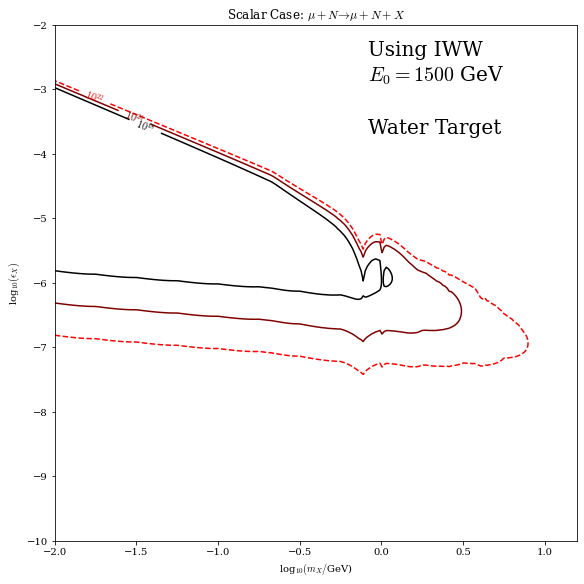

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


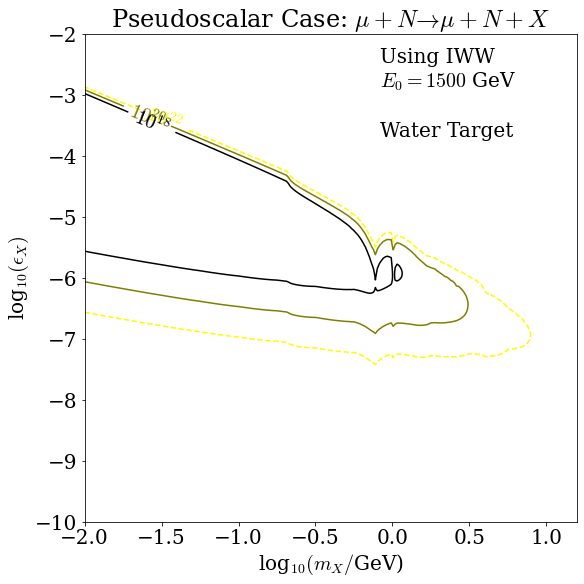

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


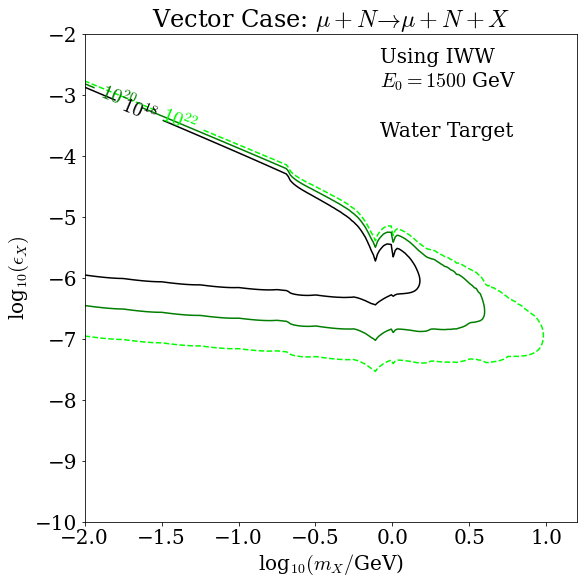

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


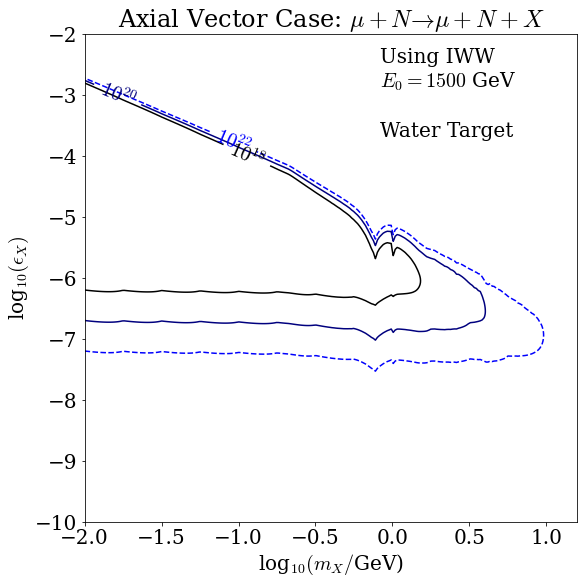

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
# mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'


try:
    from rikabtools.plot_utils import cmaps
    use_boring_colors = False
    colors = ["red", "yellow", "green", "blue"]
except:
    # if rikabtools color gradients not available, make do
    use_boring_colors = True
    default_colormaps = ["Reds", "YlOrBr", "Greens", "Blues"]

m_X_linspace = np.linspace(-2, 1.5, 250)
epsilon_linspace = np.linspace(-9, -2, 250)
Mlin, Elin = np.meshgrid(m_X_linspace, epsilon_linspace)

# function to load the event counts dictionary from the default directory
def load_events_dict(config):

    experiment_name_string_ = f"experiments/{config['Target Name']}/experiment_{config['Model String']}_e{config['E_0']}_t{config['Target Length']}_s{config['Shield Length']}_d{config['Detector Length']}"
    return np.load(f"{experiment_name_string_}/event_counts.npy", allow_pickle=True)[()]



# Function to plot a single contour
def plot_contour(case, c, evs, weight = np.log10(5), color = "", color_weight = 1, label = ""):


    white_events = np.log10(evs[case])
    white_events[white_events  < 0 ] = np.NaN
    if not use_boring_colors:
        if color == "":
            color = cmaps[colors[c]](0.99 * color_weight)
        contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
    else:
        contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True", cmap =  default_colormaps[c])#, levels = [5], colors = [colors[i]])
    if label == "":
        plt.clabel(contours, inline=True, levels=[weight,])
    else:
        plt.clabel(contours, inline=True, levels=[weight,], fmt = {contours.levels[0] : label})



for (c, case) in enumerate(cases):
    if c < 4:

        plt.rcParams.update({'font.size': 20})
        fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))


        events = load_events_dict(config)
        plot_contour(case, c, events, weight = np.log10(5e-2), color_weight = 1, label= "$10^{22}$")
        plot_contour(case, c, events, weight = np.log10(5e0), color_weight = 0.5, label= "$10^{20}$")
        plot_contour(case, c, events, weight = np.log10(5e2), color_weight = 0.0, label= "$10^{18}$")


        plt.xlabel("log$_{10}(m_X/$GeV)")
        plt.ylabel("log$_{10}(\epsilon_X)$")
        plt.title(f"{case} Case: " + r"$\mu+N \to \mu+N+X$")

        if not run_WW:
            plt.text(0.6, 0.99 - 0.05*1, r"Using IWW", fontsize = 20, transform = plt.gca().transAxes)
        else:
            plt.text(0.6, 0.99 - 0.05*1, r"Using WW", fontsize = 20, transform = plt.gca().transAxes)
        plt.text(0.6, 0.99 - 0.05*2, r"$E_0 = %d$ GeV" % E_0, fontsize = 20, transform = plt.gca().transAxes)
        # plt.text(0.6, 0.99 - 0.05*3, r"$N_\mu = 10^{20}$", fontsize = 20, transform = plt.gca().transAxes)
        plt.text(0.6, 0.99 - 0.05*4, f"{target_name} Target", fontsize = 20, transform = plt.gca().transAxes)
        plt.legend(frameon = False, loc = "upper left")

        # plt.savefig(f"tex/Figures/exclusions_{case}_{E_0}.pdf", transparent = False)
        plt.savefig(f"{config['Experiment Directory']}/exclusions_{case}.pdf", transparent = False)
        plt.show()